This workshop is available from the [Wallaroo Workshop GitHub Repository](https://github.com/WallarooLabs/Workshops/blob/main/Edge-Deployment).

## Computer Vision Yolov8n Deployment in Wallaroo

The [Yolov8](https://github.com/ultralytics/ultralytics) computer vision model is used for fast recognition of objects in images.  This tutorial demonstrates how to:

* Deploy a Yolov8n pre-trained model into a Wallaroo Ops server and perform inferences on it.
* Publish the pipeline to the OCI registry configured in the Wallaroo Ops server.
* Add an edge location to the Wallaroo pipeline publish.
* Deploy the pipeline as a Wallaroo Server on an edge device through Docker, and display the inference logs submitted to the Wallaroo Ops server.

Wallaroo Ops Center provides the ability to publish Wallaroo pipelines to an Open Continer Initative (OCI) compliant registry, then deploy those pipelines on edge devices as Docker container or Kubernetes pods.  See [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/20230300/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/) for full details.

For this tutorial, the helper module `CVDemoUtils` and `WallarooUtils` are used to transform a sample image into a pandas DataFrame.  This DataFrame is then submitted to the Yolov8n model deployed in Wallaroo.

## References

* [Wallaroo Workspaces](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/):  Workspaces are environments were users upload models, create pipelines and other artifacts.  The workspace should be considered the fundamental area where work is done.  Workspaces are shared with other users to give them access to the same models, pipelines, etc.
* [Wallaroo Model Upload and Registration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/): ML Models are uploaded to Wallaroo through the SDK or the MLOps API to a **workspace**.  ML models include default runtimes (ONNX, Python Step, and TensorFlow) that are run directly through the Wallaroo engine, and containerized runtimes (Hugging Face, PyTorch, etc) that are run through in a container through the Wallaroo engine.
* [Wallaroo Pipelines](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/): Pipelines are used to deploy models for inferencing.  Each model is a **pipeline step** in a pipelines, where the inputs of the previous step are fed into the next.  Pipeline steps can be ML models, Python scripts, or Arbitrary Python (these contain necessary models and artifacts for running a model).
* [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/20230300/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/): Details on publishing a Wallaroo pipeline to an OCI Registry and deploying it as a Wallaroo Server instance.

## Data Scientist Steps

The following details the steps a Data Scientist performs in uploading and verifying the model in a Wallaroo Ops server.

### Load Libraries

The first step is loading the required libraries including the [Wallaroo Python module](https://pypi.org/project/wallaroo/).

In [36]:
# Import Wallaroo Python SDK
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from CVDemoUtils import CVDemo
from WallarooUtils import Util
cvDemo = CVDemo()
util = Util()

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)


### Connect to the Wallaroo Instance through the User Interface

The next step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

#### Connect to the Wallaroo Instance Exercise

Connect to the Wallaroo instance.  If connecting through the JupyterHub service, then only the `wallaroo.Client()` is required.  If connecting externally through the Wallaroo SDK, use the `wallaroo.client(api_endpoint, auth_endpoint)` method.

Sample code:

```python
wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")
```

In [38]:
# Connect to the Wallaroo instance here

wl = wallaroo.Client()

### Create a New Workspace

We'll use the SDK below to create our workspace , assign as our **current workspace**, then display all of the workspaces we have at the moment.  We'll also set up variables for our models and pipelines down the road, so we have one spot to change names to whatever fits your organization's standards best.

To allow this tutorial to be run by multiple users in the same Wallaroo instance, update suffix with your first and last name.  For example:

```python
suffix = 'lazel-geth'
```

### Create a New Workspace Exercise

Set the model name, file name, pipeline name, and workspace name.

Sample code:

```python
suffix = ''

model_name = 'yolov8n'
model_filename = './models/cv-yolo/yolov8n.onnx'
pipeline_name = 'yolo8demonstration'
workspace_name = f'yolo8-edge-demonstration{suffix}'
```

In [39]:
# set helper variables here

suffix = ''

model_name = 'yolov8n'
model_filename = './models/cv-yolo/yolov8n.onnx'
pipeline_name = 'yolo8demonstration'
workspace_name = f'yolo8-edge-demonstration{suffix}'


### Set the Current Workspace

Set the current workspace where the models are uploaded to and pipelines created.

* References
  * [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)

#### Set the Current Workspace Exercise

Setting the workspace is performed with the `wallaroo.client.set_current_workspace(workspace)` method.

Sample code:

```python
workspace = get_workspace(workspace_name, wl)
wl.set_current_workspace(workspace)
```

In [ ]:
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = client.create_workspace(name)
    return workspace

workspace = get_workspace(workspace_name, wl)
wl.set_current_workspace(workspace)

### Upload the Model

When a model is uploaded to a Wallaroo cluster, it is optimized and packaged to make it ready to run as part of a pipeline. In many times, the Wallaroo Server can natively run a model without any Python overhead. In other cases, such as a Python script, a custom Python environment will be automatically generated. This is comparable to the process of "containerizing" a model by adding a small HTTP server and other wrapping around it.

Our pretrained model is in ONNX format, which is specified in the `framework` parameter.  For this model, the tensor fields are set to `images` to match the input parameters, and the batch configuration is set to `single` - only one record will be submitted at a time.

* References
  * [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: ONNX](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-upload-onnx/)

#### Upload the Model Exercise

The model name and file name were set in the variables above.  Use them to upload the model.

Sample code:

```python
yolov8_model = (wl.upload_model(model_name, 
                               model_filename, 
                               framework=Framework.ONNX)
                               .configure(tensor_fields=['images'],
                                          batch_config="single"
                                          )
                )
```

In [ ]:
# Upload Retrained Yolo8 Model 
yolov8_model = (wl.upload_model(model_name, 
                               model_filename, 
                               framework=Framework.ONNX)
                               .configure(tensor_fields=['images'],
                                          batch_config="single"
                                          )
                )

### Pipeline Deployment Configuration

For our pipeline we set the deployment configuration to only use 1 cpu and 1 GiB of RAM.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/)

#### Pipeline Deployment Configuration Exercise

Use the deployment configuration below.

In [41]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
                    .replica_count(1) \
                    .cpus(1) \
                    .memory("1Gi") \
                    .build()

### Build and Deploy the Pipeline

Now we build our pipeline and set our Yolo8 model as a pipeline step, then deploy the pipeline using the deployment configuration above.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/)

#### Build and Deploy the Pipeline

We'll do both commands in one step:

* Build the pipeline with `wallaroo.client.build_pipeline`.
* Set the model as a pipeline step with `wallaroo.pipeline.add_model_step(model)` method.

Sample code:

```python
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(yolov8_model)        
```

In [42]:
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(yolov8_model)        

### Deploy the Pipeline

We deploy the pipeline with the `wallaroo.pipeline.deploy(deployment_config)` command, using the deployment configuration set up in previous steps.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/)

### Deploy the Pipeline Exercise

Deploy the pipeline.

Sample code:

```python
pipeline.deploy(deployment_config=deployment_config)
```

In [43]:
# deploy the pipeline

pipeline.deploy(deployment_config=deployment_config)

name,yolo8demonstration
created,2023-12-06 17:28:43.045637+00:00
last_updated,2023-12-06 17:28:43.687593+00:00
deployed,True
arch,None
tags,
versions,"847e9b5c-9365-4fc0-994d-44ef74e401ef, 06ec7afa-67af-4ea7-9497-7630e371663a"
steps,yolov8n
published,False


### Convert Image to DataFrame

The sample image `dogbike.png` was converted to a DataFrame using the `cvDemo` helper modules.  The converted DataFrame is stored as `./data/dogbike.df.json` to save time.

The code sample below demonstrates how to use this module to convert the sample image to a DataFrame.

```python
# convert the image to a tensor

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('dogbike.png', width, height)
tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("data.json", orient = 'records')
```

### Inference Request

We submit the DataFrame to the pipeline using `wallaroo.pipeline.infer`, and store the results in the variable `inf1`.  A copy of the dataframe is stored in the file `./data/dogbike.df.json`.

For this, we will use our cvDemo module to resize the image and retrieve the tensor values.

#### Inference Request Exercise

To use the cvDemo, we will:

* Convert the image to a 640x640 size to fit the model's inputs.
* Create a pandas DataFrame from the image tensor data.
* Submit the inference request and save the data as a variable.

Sample code:

```python
width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('./data/cv-yolo/dogbike.png', width, height)

# convert tensor1 to a pandas DataFrame

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("./data/cv-yolo/data.df.json", orient="records")

# inf1 = pipeline.infer_from_file('./data/cv-yolo/dogbike.df.json')
inf1 = pipeline.infer(df)
```

In [44]:
# inference code here

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('./data/cv-yolo/dogbike.png', width, height)

# convert tensor1 to a pandas DataFrame

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("./data/cv-yolo/data.df.json", orient="records")

# inf1 = pipeline.infer_from_file('./data/cv-yolo/dogbike.df.json')
inf1 = pipeline.infer(df)


### Display Bounding Boxes

Using our helper method `cvDemo` we'll identify the objects detected in the photo and their bounding boxes.  Only objects with a confidence threshold of 50% or more are shown.

Note that the first inputs are the inference results from the previous inference request, and the second variable is the resized image.  Note that the first two arguments are the inference results obtained from the inference request, and the resized image.

### Display Bounding Boxes Exercise

Use the following code, modified based on the name of your inference results and resized image variables.

```python
confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(inf1, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)
```


  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.16% | Class: Car | Bounding Box: [390, 85, 186, 108]


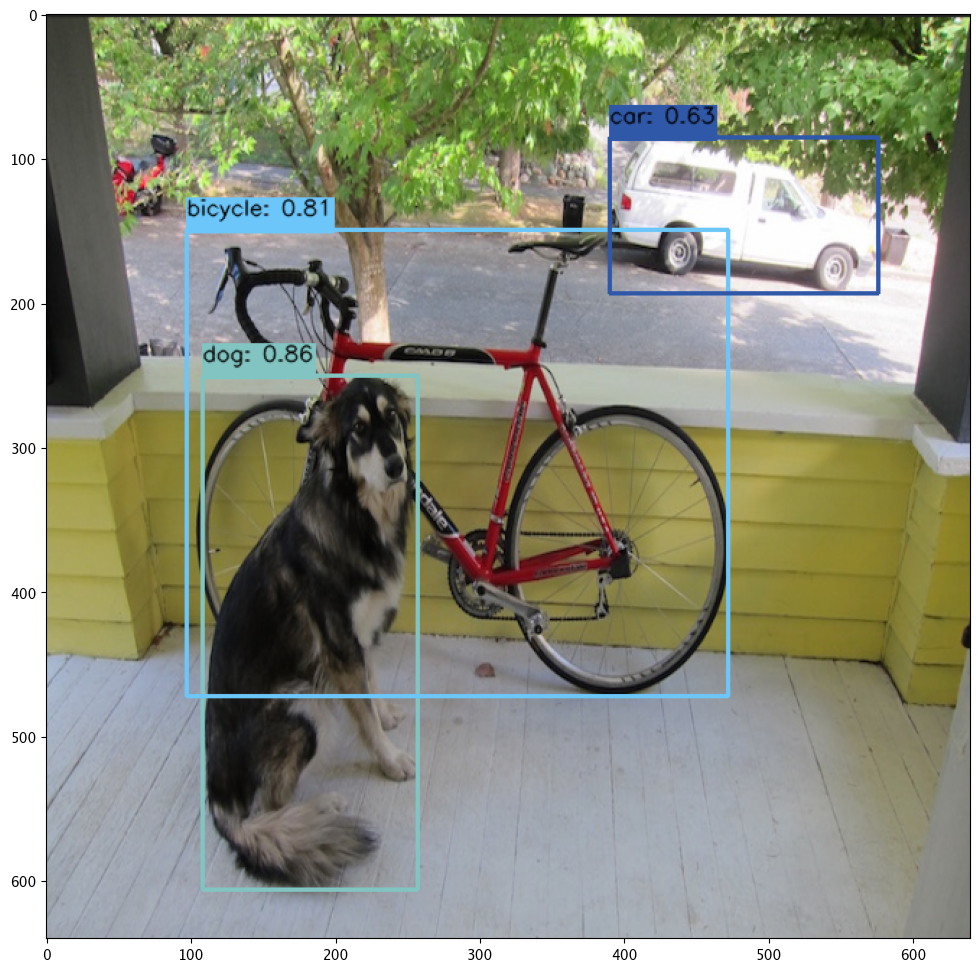

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 34,  34,  34],
        ...,
        [ 34,  34,  34],
        [ 33,  33,  33],
        [ 34,  34,  34]],

       [[ 53,  54,  48],
        [ 54,  55,  49],
        [ 54,  55,  49],
        ...,
        [153, 178, 111],
        [151, 183, 108],
        [159, 176,  99]],

       ...,

       [[159, 167, 178],
        [159, 165, 177],
        [158, 163, 175],
        ...,
        [126, 127, 121],
        [127, 125, 120],
        [128, 120, 117]],

       [[160, 168, 179],
        [156, 162, 174],
        [152, 157, 169],
        ...,
        [126, 127, 121],
        [129, 127, 122],
        [127, 118, 116]],

       [[155, 163, 174],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [45]:
# draw the bounding boxes from the inference results

confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(inf1, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

### Inference Through Pipeline API

Another method of performing an inference using the pipeline's deployment url.

Performing an inference through an API requires the following:

* The authentication token to authorize the connection to the pipeline.
* The pipeline's inference URL.
* Inference data to sent to the pipeline - in JSON, DataFrame records format, or Apache Arrow.

Full details are available through the [Wallaroo API Connection Guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-api-guide/wallaroo-mlops-connection-guide/) on how retrieve an authorization token and perform inferences through the pipeline's API.

For this demonstration we'll submit the pandas record, request a pandas record as the return, and set the authorization header.  The results will be stored in the file `curl_response.df`.

### Inference Through Pipeline API Exercise

We'll use the pipeline deployment URL to submit the inference request as an API call.  The following is sample code for adding the authentication token and setting the `Content-Type` to pandas dataFrame.

```bash
!curl -X POST {pipeline._deployment._url()} \
    -H "Authorization:{wl.auth.auth_header()['Authorization']}" \
    -H "Content-Type:application/json; format=pandas-records" \
    --data @./data/cv-yolo/data.df.json > curl_response.df
```

In [46]:
# inference request here.

!curl -X POST {pipeline._deployment._url()} \
    -H "Authorization:{wl.auth.auth_header()['Authorization']}" \
    -H "Content-Type:application/json; format=pandas-records" \
    --data @./data/cv-yolo/data.df.json > curl_response.df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.0M  100 22.9M  100 15.0M   561k   369k  0:00:41  0:00:41 --:--:--  319k00 15.0M   887k  1216k  0:00:26  0:00:12  0:00:14  352k100 15.0M   661k   521k  0:00:35  0:00:29  0:00:06  786k


### Undeploy the Pipeline

Undeploy the pipeline and return the resources back to the Wallaroo cluster.

### Undeploy the Pipeline Exercise

Sample code:

```python
pipeline.undeploy()
```

In [47]:
# undeploy the pipeline

pipeline.undeploy()


name,yolo8demonstration
created,2023-12-06 17:28:43.045637+00:00
last_updated,2023-12-06 17:28:43.687593+00:00
deployed,False
arch,None
tags,
versions,"847e9b5c-9365-4fc0-994d-44ef74e401ef, 06ec7afa-67af-4ea7-9497-7630e371663a"
steps,yolov8n
published,False


### Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)` which has the following parameters and returns.

#### Publish a Pipeline Parameters

The `publish` method takes the following parameters.  The containerized pipeline will be pushed to the Edge registry service with the model, pipeline configurations, and other artifacts needed to deploy the pipeline.

| Parameter | Type | Description |
|---|---|---|
| `deployment_config` | `wallaroo.deployment_config.DeploymentConfig` (*Optional*) | Sets the pipeline deployment configuration.  For example:    For more information on pipeline deployment configuration, see the [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/).

#### Publish a Pipeline Returns

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline version id | integer | Numerical Wallaroo id of the pipeline version published. |
| status | string | The status of the pipeline publication.  Values include:  <ul><li>PendingPublish: The pipeline publication is about to be uploaded or is in the process of being uploaded.</li><li>Published:  The pipeline is published and ready for use.</li></ul> |
| Engine URL | string | The URL of the published pipeline engine in the edge registry. |
| Pipeline URL | string | The URL of the published pipeline in the edge registry. |
| Helm Chart URL | string | The URL of the helm chart for the published pipeline in the edge registry. |
| Helm Chart Reference | string | The help chart reference. |
| Helm Chart Version | string | The version of the Helm Chart of the published pipeline.  This is also used as the Docker tag. |
| Engine Config | `wallaroo.deployment_config.DeploymentConfig` | The pipeline configuration included with the published pipeline. |
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

#### Publish Exercise

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command.  `deployment_config` is an optional field that specifies the pipeline deployment.  This can be overridden by the DevOps engineer during deployment.

Save the publish to a variable for later use.

Sample code:

```python
pub = pipeline.publish(deployment_config)
pub
```

In [48]:
pub = pipeline.publish(deployment_config)
pub

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing...Published.


ID,4
Pipeline Version,a8c5765c-eea6-4419-b71a-82d2fdf3effd
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4103
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:a8c5765c-eea6-4419-b71a-82d2fdf3effd
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/yolo8demonstration
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:a20a482ed14c9cf9ee8c96790b39dad415edc9c90a9541b5585b715ede740ac6
Helm Chart Version,0.0.1-a8c5765c-eea6-4419-b71a-82d2fdf3effd
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}, 'engineAux': {'images': {}}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


### List Published Pipeline

The method `wallaroo.client.list_pipelines()` shows a list of all pipelines in the Wallaroo instance, and includes the `published` field that indicates whether the pipeline was published to the registry (`True`), or has not yet been published (`False`).

#### List Published Pipeline Exercise

List the pipelines and verify which ones are published or not.

Sample code:

```python
wl.list_pipelines()
```

In [49]:
# list pipelines

wl.list_pipelines()

name,created,last_updated,deployed,arch,tags,versions,steps,published
yolo8demonstration,2023-06-Dec 17:28:43,2023-06-Dec 17:31:15,False,None,,"a8c5765c-eea6-4419-b71a-82d2fdf3effd, 847e9b5c-9365-4fc0-994d-44ef74e401ef, 06ec7afa-67af-4ea7-9497-7630e371663a",yolov8n,True
yolo8demonstration,2023-06-Dec 15:42:29,2023-06-Dec 15:42:30,True,None,,"1ef22566-c988-4e3b-9428-621d29bd9da6, fafa986f-691e-45ff-a621-11e16669a76c",yolov8n,False
retail-forecast,2023-05-Dec 23:13:01,2023-05-Dec 23:14:13,False,None,,"4dfc8337-a4f2-42ce-b5ca-c401f29dddeb, 5d051000-de45-4167-b992-c6d092d2cb2e, 782b178a-ad0f-43a8-8ebc-d00e059a5f2b",forecast-control-model,True
llm-edge-summarization,2023-05-Dec 20:48:36,2023-05-Dec 20:50:14,False,None,,"1c8d0586-f3ff-453c-82a9-14602830f97f, 040afe0c-9a17-4f0b-8cb2-68e8dc85d9a4, 6f1db20f-e1b5-47a5-a6b4-c6a31f9c1023",llm-summarization,True


### List Publishes from a Pipeline

All publishes created from a pipeline are displayed with the `wallaroo.pipeline.publishes` method.  The `pipeline_version_id` is used to know what version of the pipeline was used in that specific publish.  This allows for pipelines to be updated over time, and newer versions to be sent and tracked to the Edge Deployment Registry service.

#### List Publishes Parameters

N/A

#### List Publishes Returns

A List of the following fields:

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline_version_id | integer | Numerical Wallaroo id of the pipeline version published. |
| engine_url | string | The URL of the published pipeline engine in the edge registry. |
| pipeline_url | string | The URL of the published pipeline in the edge registry. |
| created_by | string | The email address of the user that published the pipeline.
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

#### List Publishes from a Pipeline Exercise

List the publishes from a pipeline.

Sample code:

```python
pipeline.publishes()
```

In [50]:
# list the pipeline publishes

pipeline.publishes()

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
4,a8c5765c-eea6-4419-b71a-82d2fdf3effd,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4103,ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:a8c5765c-eea6-4419-b71a-82d2fdf3effd,john.hummel@wallaroo.ai,2023-06-Dec 17:31:16,2023-06-Dec 17:31:16


### Add Edge Location

With the pipeline publish created, we can add an Edge Location.  This allows the edge deployment to upload its inference results back to the Wallaroo Ops location, which are then added to the pipeline the publish originated from.  These are added to the pipeline logs `partition` metadata.

First we'll retrieve the pipeline logs for our current pipeline, and show the current pipeline logs metadata.

Then we'll add the edge location we'll deploy with the `wallaroo.pipeline_publish.add_edge(name: string, tags: List[string]) ` method.

For the edge name, set it to `firstname-lastname-edge-yolo`.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Log Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-logs/)
  * [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/#add-edge)

#### Add Edge Location Exercise

Display the log information with the `metadata.partition`, then add the edge location to the publish.  Note that edge names **must** be unique, so add your first and last name to the list.

Sample code:

```python
logs = pipeline.logs(dataset=['time', 'out.output0', 'metadata'])
display(logs.loc[:, ['time', 'metadata.partition']])

first_last_name = '-Gale-Karlach'

edge_name = f'yolo-edge-demo{first_last_name}'

edge_publish = pub.add_edge(edge_name)
display(edge_publish)
```


In [51]:
# display log information here with partition

logs = pipeline.logs(dataset=['time', 'out.output0', 'metadata'])
display(logs.loc[:, ['time', 'metadata.partition']])

,time,metadata.partition
0,2023-12-06 17:29:34.053,engine-57cf86577f-t4jpr


In [52]:
# add edge here
edge_name = 'yolo-edge-demo-2'

edge_publish = pub.add_edge(edge_name)
display(edge_publish)

ID,4
Pipeline Version,a8c5765c-eea6-4419-b71a-82d2fdf3effd
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4103
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:a8c5765c-eea6-4419-b71a-82d2fdf3effd
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/yolo8demonstration
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:a20a482ed14c9cf9ee8c96790b39dad415edc9c90a9541b5585b715ede740ac6
Helm Chart Version,0.0.1-a8c5765c-eea6-4419-b71a-82d2fdf3effd
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}, 'engineAux': {'images': {}}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.

### Docker Deployment

First, the DevOps engineer must authenticate to the same OCI Registry service used for the Wallaroo Edge Deployment registry.

For more details, check with the documentation on your artifact service.  The following are provided for the three major cloud services:

* [Set up authentication for Docker](https://cloud.google.com/artifact-registry/docs/docker/authentication)
* [Authenticate with an Azure container registry](https://learn.microsoft.com/en-us/azure/container-registry/container-registry-authentication?tabs=azure-cli)
* [Authenticating Amazon ECR Repositories for Docker CLI with Credential Helper](https://aws.amazon.com/blogs/compute/authenticating-amazon-ecr-repositories-for-docker-cli-with-credential-helper/)

For the deployment, the engine URL is specified with the following environmental variables:

* `DEBUG` (true|false): Whether to include debug output.
* `OCI_REGISTRY`: The URL of the registry service.
* `CONFIG_CPUS`: The number of CPUs to use.
* `OCI_USERNAME`: The edge registry username.
* `OCI_PASSWORD`:  The edge registry password or token.
* `PIPELINE_URL`: The published pipeline URL.

#### Docker Deployment Example

Using our sample environment, here's sample deployment using Docker with a computer vision ML model, the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail](https://docs.wallaroo.ai/wallaroo-use-case-tutorials/wallaroo-use-case-computer-vision/use-case-computer-vision-retail/) tutorials.

Note the use of the `-v ./data:/persist` option.  This will store the one time authentication token stored in the `EDGE_BUNDLE`

```bash
mkdir ./data

docker run -p 8080:8080 \
    -v ./data:/persist \
    -e DEBUG=true -e OCI_REGISTRY={your registry server} \
    -e EDGE_BUNDLE={edge_publish.docker_run_variables['EDGE_BUNDLE']} \
    -e CONFIG_CPUS=4 \
    -e OCI_USERNAME=oauth2accesstoken \
    -e OCI_PASSWORD={registry token here} \
    -e PIPELINE_URL={your registry server}/pipelines/yolo8demonstration:bf70eaf7-8c11-4b46-b751-916a43b1a555 \
    {your registry server}/engine:v2023.3.0-main-3707
```

### Docker Compose Deployment

For users who prefer to use `docker compose`, the following sample `compose.yaml` file is used to launch the Wallaroo Edge pipeline.  This is the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail](https://docs.wallaroo.ai/wallaroo-use-case-tutorials/wallaroo-use-case-computer-vision/use-case-computer-vision-retail/) tutorials.

The `volumes` settings allows for persistent volumes to store the session information.  Without it, the one-time authentication token included in the `EDGE_BUNDLE` settings would have to be regenerated.

```yml
services:
  engine:
    image: {Your Engine URL}
    volumes:
      - ./data:/persist
    ports:
      - 8080:8080
    environment:
      EDGE_BUNDLE: abcdefg
      PIPELINE_URL: {Your Pipeline URL}
      OCI_REGISTRY: {Your Edge Registry URL}
      OCI_USERNAME:  {Your Registry Username}
      OCI_PASSWORD: {Your Token or Password}
      CONFIG_CPUS: 4
```

For example:

```yml
services:
  engine:
    image: sample-registry.com/engine:v2023.3.0-main-3707
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: sample-registry.com/pipelines/yolo8demonstration:bf70eaf7-8c11-4b46-b751-916a43b1a555
      OCI_REGISTRY: sample-registry.com
      OCI_USERNAME:  _json_key_base64
      OCI_PASSWORD: abc123
      CONFIG_CPUS: 4
```

#### Docker Compose Deployment Example

The deployment and undeployment is then just a simple `docker compose up` and `docker compose down`.  The following shows an example of deploying the Wallaroo edge pipeline using `docker compose`.

```bash
docker compose up
[+] Running 1/1
 ✔ Container yolo8demonstration-engine-1  Recreated                                                                                                                                                                 0.5s
Attaching to yolo8demonstration-engine-1
yolo8demonstration-engine-1  | Wallaroo Engine - Standalone mode
yolo8demonstration-engine-1  | Login Succeeded
yolo8demonstration-engine-1  | Fetching manifest and config for pipeline: sample-registry.com/pipelines/yolo8demonstration:bf70eaf7-8c11-4b46-b751-916a43b1a555
yolo8demonstration-engine-1  | Fetching model layers
yolo8demonstration-engine-1  | digest: sha256:c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
yolo8demonstration-engine-1  |   filename: c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
yolo8demonstration-engine-1  |   name: yolov8n
yolo8demonstration-engine-1  |   type: model
yolo8demonstration-engine-1  |   runtime: onnx
yolo8demonstration-engine-1  |   version: 693e19b5-0dc7-4afb-9922-e3f7feefe66d
yolo8demonstration-engine-1  |
yolo8demonstration-engine-1  | Fetched
yolo8demonstration-engine-1  | Starting engine
yolo8demonstration-engine-1  | Looking for preexisting `yaml` files in //modelconfigs
yolo8demonstration-engine-1  | Looking for preexisting `yaml` files in //pipelines
```

### Helm Deployment

Published pipelines can be deployed through the use of helm charts.

Helm deployments take up to two steps - the first step is in retrieving the required `values.yaml` and making updates to override.

Kubernetes provides persistent volume support, so no settings are required.

1. Pull the helm charts from the published pipeline.  The two fields are the Helm Chart URL and the Helm Chart version to specify the OCI .    This typically takes the format of:

  ```bash
  helm pull oci://{published.helm_chart_url} --version {published.helm_chart_version}
  ```

1. Extract the `tgz` file and copy the `values.yaml` and copy the values used to edit engine allocations, etc.  The following are **required** for the deployment to run:

  ```yml
  ociRegistry:
    registry: {your registry service}
    username:  {registry username here}
    password: {registry token here}
  ```

  Store this into another file, suc as `local-values.yaml`.

1. Create the namespace to deploy the pipeline to.  For example, the namespace `wallaroo-edge-pipeline` would be:

  ```bash
  kubectl create -n wallaroo-edge-pipeline
  ```

1. Deploy the `helm` installation with `helm install` through one of the following options:
    1. Specify the `tgz` file that was downloaded and the local values file.  For example:

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {tgz path}
        ```

    1. Specify the expended directory from the downloaded `tgz` file.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {helm directory path}
        ```

    1. Specify the Helm Pipeline Helm Chart and the Pipeline Helm Version.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} oci://{published.helm_chart_url} --version {published.helm_chart_version}
        ```

1. Once deployed, the DevOps engineer will have to forward the appropriate ports to the `svc/engine-svc` service in the specific pipeline.  For example, using `kubectl port-forward` to the namespace `ccfraud` that would be:

    ```bash
    kubectl port-forward svc/engine-svc -n ccfraud01 8080 --address 0.0.0.0`
    ```

### Docker Deployment Code Generation Exercise

The following code segment generates a `docker run` template based on the previously published pipeline.  Replace the `$REGISTRYURL`, `$REGISTRYUSERNAME`, and `$REGISTRYPASSWORD` to match the OCI Registry being used.

In [ ]:
docker_deploy = f'''
mkdir ./data \
docker run -p 8080:8080 \\
    -v ./data:/persist \\
    -e DEBUG=true \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e EDGE_BUNDLE={edge_publish.docker_run_variables['EDGE_BUNDLE']} \\
    -e CONFIG_CPUS=1 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={edge_publish.pipeline_url} \\
    {edge_publish.engine_url}
'''

print(docker_deploy)

## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

```bash
curl localhost:8080/pipelines
{"pipelines":[{"id":"yolo8demonstration","status":"Running"}]}
```

The following example uses the host `workshop-yolo8n-x86-demo.eastus.cloudapp.azure.com`.  Replace with your own host name of your Edge deployed pipeline.

In [ ]:
!curl workshop-yolo8n-x86-demo.eastus.cloudapp.azure.com:8080/pipelines

The endpoint `/models` returns a List of models with the following fields:

* **name** (*String*): The model name.
* **sha** (*String*): The sha hash value of the ML model.
* **status** (*String*):  The status of either Running or Error if there are any issues.
* **version** (*String*):  The model version.  This matches the version designation used by Wallaroo to track model versions in UUID format.

```bash
{"models":[{"name":"yolov8n","sha":"3ed5cd199e0e6e419bd3d474cf74f2e378aacbf586e40f24d1f8c89c2c476a08","status":"Running","version":"7af40d06-d18f-4b3f-9dd3-0a15248f01c8"}]}
```

The following example uses the host `workshop-yolo8n-x86-demo.eastus.cloudapp.azure.com`.  Replace with your own host name of your Edge deployed pipeline.

In [ ]:
!curl workshop-yolo8n-x86-demo.eastus.cloudapp.azure.com:8080/models

### Edge Inference Endpoint

The inference endpoint takes the following pattern:

* `/pipelines/{pipeline-name}`:  The `pipeline-name` is the same as returned from the [`/pipelines`](#list-pipelines) endpoint as `id`.

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.

Once deployed, we can perform an inference through the deployment URL.

The endpoint returns `Content-Type: application/json; format=pandas-records` by default with the following fields:

* **check_failures** (*List[Integer]*): Whether any validation checks were triggered.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Anomaly Testing](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#anomaly-testing).
* **elapsed** (*List[Integer]*): A list of time in nanoseconds for:
  * [0] The time to serialize the input.
  * [1...n] How long each step took.
* **model_name** (*String*): The name of the model used.
* **model_version** (*String*): The version of the model in UUID format.
* **original_data**: The original input data.  Returns `null` if the input may be too long for a proper return.
* **outputs** (*List*): The outputs of the inference result separated by data type, where each data type includes:
  * **data**: The returned values.
  * **dim** (*List[Integer]*): The dimension shape returned.
  * **v** (*Integer*): The vector shape of the data.
* **pipeline_name**  (*String*): The name of the pipeline.
* **shadow_data**: Any shadow deployed data inferences in the same format as **outputs**.
* **time** (*Integer*): The time since UNIX epoch.
  
Once deployed, we can perform an inference through the deployment URL.  We'll assume we're running the inference request through the localhost and submitting the local file `./data/dogbike.df.json`.  Note that our inference endpoint is `pipelines/yolo8demonstration` - the same as our pipeline name.

The following example demonstrates sending an inference request to the edge deployed pipeline and storing the results in a pandas DataFrame in record format.  The results can then be exported to other processes to render the detected images or other use cases.

The following example uses the host `workshop-yolo8n-x86-demo.eastus.cloudapp.azure.com`.  Replace with your own host name of your Edge deployed pipeline.

In [ ]:
!curl -X POST workshop-yolo8n-x86-demo.eastus.cloudapp.azure.com:8080/pipelines/yolo-v8 \
    -H "Content-Type: application/json; format=pandas-records" \
    --data @./data/cv-yolo/dogbike.df.json